#Model-Agnostic Meta Learning (MAML)

This is an exploration of the concept of Model-Agnostic Meta Learning (MAML) as described in the 2017 paper [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks](https://arxiv.org/abs/1703.03400). MAML is a fascinating algorithm given how there are such few assumptions on the model one chooses to use—the only being trainability by gradient descent.

In the below application we seek to learn a linear approximation to perturbed step data. We define the perturbed step data by sampling observations uniformly from $J=[-x,x]$ for $x \in \mathcal{R}$, translating them step-wise throughout—a translation for each $(k,k+1)$ with $k \in \mathcal{Z} \subset J$—, and adding perturbations. Then we shall use MAML to train a single, task-generic set of weights, defining a meta-objective as the loss on any particular task (training regression problem) after K steps of gradient descent.



Our architecture is a Multilayer Perceptron (MLP) with Rectified Linear (ReLU) activations, two hidden layers, and a Mean Squared Error loss function for our internal objective. We consider a dataset defined on the interval $[-3,3]$, like the following:

In [0]:
import autograd.numpy as np
import autograd as ag
from matplotlib import pyplot as plt

def relu(z):
    return np.maximum(z, 0.)

def net_predict(params, x):
    """Compute the output of a ReLU MLP with 2 hidden layers."""
    H1 = relu(np.outer(x, params['W1']) + params['b1'])
    H2 = relu(np.dot(H1, params['W2']) + params['b2'])
    return np.dot(H2, params['w3']) + params['b3']

def random_init(std, nhid):
    return {'W1': np.random.normal(0, std, size=nhid),
            'b1': np.random.normal(0., std, size=nhid),
            'W2': np.random.normal(0., std, size=(nhid,nhid)),
            'b2': np.random.normal(0., std, size=nhid),
            'w3': np.random.normal(0., std, size=nhid),
            'b3': np.random.normal(0., std)}
    
class ToyDataGen:
    """Samples a random piecewise linear function, and then samples noisy
    observations of the function."""
    def __init__(self, xmin, xmax, ymin, ymax, std, num_pieces):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.std = std
        self.num_pieces = num_pieces
        
    def sample_dataset(self, npts):
        x = np.random.uniform(self.xmin, self.xmax, size=npts)
        heights = np.random.uniform(self.ymin, self.ymax, size=self.num_pieces)
        bins = np.floor((x - self.xmin) / (self.xmax - self.xmin) * self.num_pieces).astype(int)
        y = np.random.normal(heights[bins], self.std)
        return x, y
    
def gd_step(cost, params, lrate):
    """Perform one gradient descent step on the given cost function with learning
    rate lrate. Returns a new set of parameters, and (IMPORTANT) does not modify
    the input parameters."""
    
    grad_cost = ag.grad(cost)
    cost_params = grad_cost(params)
    params_new = {}
    
    params_new['W1'] = params['W1'] - lrate * cost_params['W1']
    params_new['b1'] = params['b1'] - lrate * cost_params['b1']
    params_new['W2'] = params['W2'] - lrate * cost_params['W2']
    params_new['b2'] = params['b2'] - lrate * cost_params['b2']
    params_new['w3'] = params['w3'] - lrate * cost_params['w3']
    params_new['b3'] = params['b3'] - lrate * cost_params['b3']

    return params_new


class InnerObjective:
    """Mean squared error."""
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __call__(self, params):
        return 0.5 * np.mean((self.y - net_predict(params, self.x)) ** 2)
    
class MetaObjective:
    """Mean squared error after some number of gradient descent steps
    on the inner objective."""
    def __init__(self, x, y, inner_lrate, num_steps):
        self.x = x
        self.y = y
        self.inner_lrate = inner_lrate
        self.num_steps = num_steps
        
    def __call__(self, params, return_traj=False):
        """Compute the meta-objective. If return_traj is True, you should return
        a list of the parameters after each update. (This is used for visualization.)"""
        trajectory = [params]
        trajectory_new = {}
        worker = InnerObjective(self.x, self.y)
		
		    # Update parameters and append each update to list
        while len(trajectory) <= self.num_steps:
            trajectory_new = gd_step(worker, trajectory[-1], self.inner_lrate)
            trajectory.append(trajectory_new)

        final_cost = worker(trajectory[-1])

        if return_traj:
            return final_cost, trajectory
        else:
            return final_cost
    
    def visualize(self, params, title, ax):
        _, trajectory = self(params, return_traj=True)
        
        ax.plot(self.x, self.y, 'bx', ms=3.)
        px = np.linspace(XMIN, XMAX, 1000)
        for i, new_params in enumerate(trajectory):
            py = net_predict(new_params, px)
            ax.plot(px, py, 'r-', alpha=(i+1)/len(trajectory))
        ax.set_title(title)


OUTER_LRATE = 0.01
OUTER_STEPS = 12000
INNER_LRATE = 0.1
INNER_STEPS = 5

PRINT_EVERY = 100
DISPLAY_EVERY = 1000

XMIN = -3
XMAX = 3
YMIN = -3
YMAX = 3
NOISE = 0.1
BINS = 6
NDATA = 100

INIT_STD = 0.1
NHID = 50

def train():
    np.random.seed(0)
    data_gen = ToyDataGen(XMIN, XMAX, YMIN, YMAX, NOISE, BINS)
    params = random_init(INIT_STD, NHID)
    fig, ax = plt.subplots(3, 4, figsize=(16, 9))
    plot_id = 0
    
    # Generate validation set
    x_val, y_val = data_gen.sample_dataset(NDATA)
    
    for i in range(OUTER_STEPS):
       
        # Sample regression dataset for training
        x_train, y_train = data_gen.sample_dataset(NDATA)

        # Grad descent
        val_cost = MetaObjective(x_train, y_train, INNER_LRATE, INNER_STEPS)
        new_params = gd_step(val_cost, params, OUTER_LRATE)
        params = new_params
        
        if (i+1) % PRINT_EVERY == 0:
            val_cost = MetaObjective(x_val, y_val, INNER_LRATE, INNER_STEPS)
            print('Iteration %d Meta-objective: %1.3f' % (i+1, val_cost(params)))
        
        #print('Outer cost:', cost(params))
        if (i+1) % DISPLAY_EVERY == 0:
            val_cost.visualize(params, 'Iteration %d' % (i+1), ax.flat[plot_id])
            plot_id += 1


We train our model by calling ```train()``` below. 

The above program will produce visualizations that show the progression of our learning task on the validation data set. We should see better approximations (red lines below) to the validation set as the training progresses even though we are sampling different regression data sets at every iteration.

Iteration 100 Meta-objective: 1.254
Iteration 200 Meta-objective: 1.226
Iteration 300 Meta-objective: 1.215
Iteration 400 Meta-objective: 1.190
Iteration 500 Meta-objective: 1.177
Iteration 600 Meta-objective: 1.160
Iteration 700 Meta-objective: 1.137
Iteration 800 Meta-objective: 1.124
Iteration 900 Meta-objective: 1.087
Iteration 1000 Meta-objective: 1.056
Iteration 1100 Meta-objective: 1.039
Iteration 1200 Meta-objective: 1.030
Iteration 1300 Meta-objective: 1.018
Iteration 1400 Meta-objective: 1.004
Iteration 1500 Meta-objective: 0.995
Iteration 1600 Meta-objective: 0.986
Iteration 1700 Meta-objective: 0.971
Iteration 1800 Meta-objective: 0.978
Iteration 1900 Meta-objective: 0.960
Iteration 2000 Meta-objective: 0.939
Iteration 2100 Meta-objective: 0.911
Iteration 2200 Meta-objective: 0.891
Iteration 2300 Meta-objective: 0.893
Iteration 2400 Meta-objective: 0.883
Iteration 2500 Meta-objective: 0.881
Iteration 2600 Meta-objective: 0.860
Iteration 2700 Meta-objective: 0.831
Iteration 

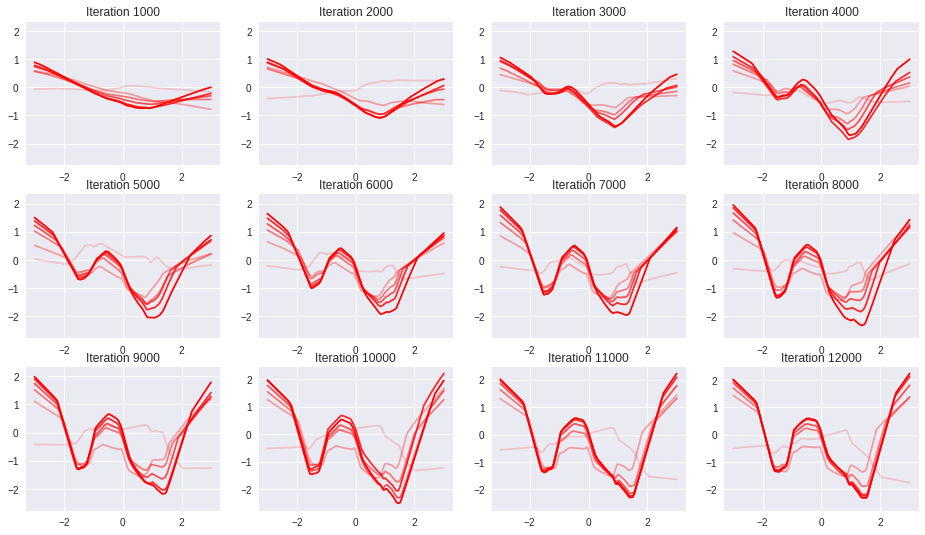

In [0]:
train()